# Курсовая "Модель предсказания цены на недвижимость"

Нужно будет оформить ноутбук с основными этапами:
1. подготовка данных
    * анализ
    * визуализация
    * обработка выбросов
    * обработка пропусков
    * генерация фичей
2. обучение модели
3. проверка качества модели

Так же надо отправить файл с предсказаниями на kaggle и на private leaderboard получить больше 0.6

Данные для курсового можно брать отсюда https://www.kaggle.com/t/b4c9382d4f934176af9fe860b1976528 (вкладка data)

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.
____________
Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. По возможности добавлять графики, описывающие данные (около 3-5)
4. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
5. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
6. Весь проект должен быть в одном скрипте (файл ipynb).
7. При использовании статистик (среднее, медиана и т.д.) в качестве признаков, лучше считать их на трейне, и потом на валидационных и тестовых данных не считать статистики заново, а брать их с трейна.
8. Проект должен полностью отрабатывать за разумное время (не больше 10 минут), поэтому в финальный вариант лучше не включать GridSearch с перебором большого количества сочетаний параметров. 

**Содержание**
* [0. Загрузка данных](#load)
* [1. Разведочный анализ данных](#eda)
* [2. Обработка выбросов](#outlier)
* [3. Обработка пропусков](#nan)
* [4. Построение новых признаков](#feature)
* [5. Отбор признаков](#feature_selection)
* [6. Разбиение на train и test](#split)
* [7. Построение модели](#modeling)
* [8. Прогнозирование на тестовом датасете](#prediction)

**Подключение библиотек и скриптов**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv
/kaggle/input/real-estate-price-prediction-moscow/train.csv
/kaggle/input/real-estate-price-prediction-moscow/test.csv


In [2]:
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
random.seed(42)

In [5]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

**Пути к директориям и файлам**

In [6]:
# Input
SAMPLE_DATASET_PATH = '/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv'
TRAIN_DATASET_PATH = '/kaggle/input/real-estate-price-prediction-moscow/train.csv'
TEST_DATASET_PATH = '/kaggle/input/real-estate-price-prediction-moscow/test.csv'

# Output
RESULT = 'rf_submit.csv'

### Загрузка данных <a class='anchor' id='load'>

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [7]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

In [8]:
assert(train_df.shape[1] - 1 == test_df.shape[1])

In [9]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


### Приведение типов

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [11]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

## 1. Разведочный анализ данных  <a class='anchor' id='eda'>
Делаем EDA для:
- Исправления выбросов
- Заполнения NaN
- Идей для генерации новых фич

**Целевая переменная**

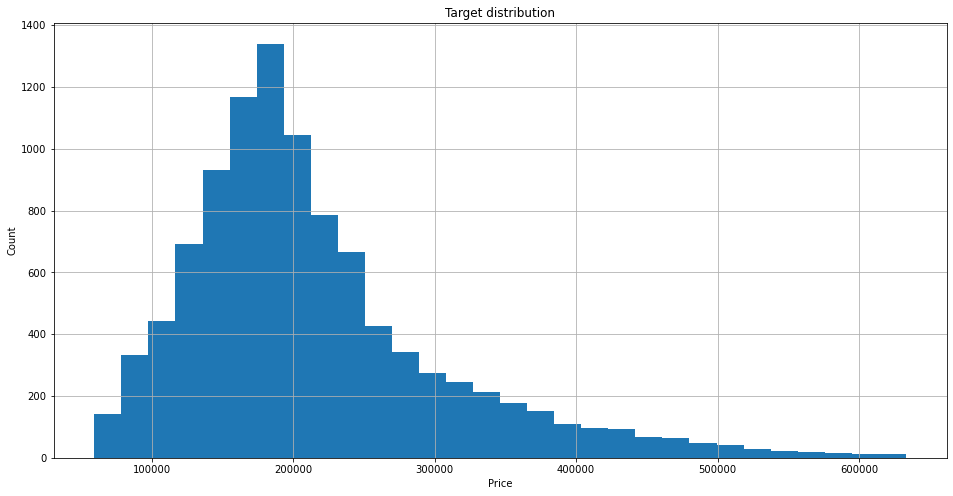

In [12]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution');

In [13]:
# correlation = train_df.corrwith(train_df['Price']).sort_values(ascending=False)
# correlation.drop('Price', inplace=True)

# plt.figure(figsize = (16, 8))
# plt.bar(correlation.index, correlation)
# plt.xticks(rotation='90')
# plt.xlabel('Features', fontsize=15)
# plt.ylabel('Correlation', fontsize=15)
# plt.title('Feature correlation', fontsize=15)
# plt.show()

**Количественные переменные**

In [14]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


**Номинативные переменные**

In [15]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [16]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
174      1
207      1
199      1
196      1
117      1
Name: DistrictId, Length: 205, dtype: int64

In [17]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [18]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [19]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### 2. Обработка выбросов  <a class='anchor' id='outlier'>
Что можно делать с ними?
1. Выкинуть эти данные (только на трейне, на тесте ничего не выкидываем)
2. Заменять выбросы разными методами (медианы, средние значения, np.clip и т.д.)
3. Делать/не делать дополнительную фичу
4. Ничего не делать

**Rooms**

In [20]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [21]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.871089,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.553407,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.720850,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.007630,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.102962,0


In [22]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

In [23]:
train_df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

**KitchenSquare** 

In [24]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
43.0         2
112.0        2
41.0         2
32.0         2
58.0         2
25.0         2
37.0         2
30.0         2
51.0         2
40.0         1
96.0         1
48.0         1
72.0         1
73.0         1
2014.0       1
66.0         1
36.0         1
78.0         1
54.0         1
29.0         1
31.0         1
35.0         1
62.0         1
39.0         1
1970.0       1
60.0         1
75.0         1
26.0         1
21.0         1
84.0         1
63.0         1
123.0        1
53.0         1
42.0         1
23.0         1
27.0         1
Name: KitchenSquare, dtype: int64

In [25]:
train_df['KitchenSquare'].quantile(.975), train_df['KitchenSquare'].quantile(.025)

(13.0, 0.0)

In [26]:
condition = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))
        
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()

train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [27]:
train_df['KitchenSquare'].value_counts()

3.0     3183
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
Name: KitchenSquare, dtype: int64

**HouseFloor, Floor**

In [28]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [29]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42])

In [30]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

In [31]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

In [32]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [33]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1610)

In [34]:
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor']\
                                                .apply(lambda x: random.randint(1, x))

In [35]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

**HouseYear**

In [36]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7246        2020
2350        2020
8296        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int64

In [37]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

### 3. Обработка пропусков  <a class='anchor' id='nan'>

In [38]:
train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
HouseFloor_outlier       0
dtype: int64

In [39]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,115.027311,NaN,10.0
1,39.832524,23.169223,8.0
2,78.342215,47.671972,10.0
3,40.409907,NaN,3.0
4,64.285067,38.562517,9.0
5,62.528465,47.103833,6.0
6,33.938750,21.772930,9.0
7,50.391814,32.893256,8.0
8,46.887892,44.628132,3.0
9,79.867477,75.085125,3.0


**LifeSquare**

In [40]:
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

condition = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())
        
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                            - train_df.loc[condition, 'KitchenSquare'] - 3

Healthcare_1

In [41]:
train_df.drop('Healthcare_1', axis=1, inplace=True)

In [42]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.887600,56.315775,40.734674,6.238200,7.397900,12.95910,1984.872400,0.118858,24.687000,5352.157400,8.039200,1.319500,4.231300,214138.857399,0.001200,0.182500,0.211300
std,0.811438,21.058732,77.610357,2.794717,5.035426,6.44346,18.416347,0.119025,17.532614,4006.799803,23.831875,1.493601,4.806341,92872.293865,0.034622,0.386275,0.408251
min,1.000000,1.136859,0.370619,3.000000,1.000000,1.00000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000
25%,1.000000,41.774881,25.285992,3.000000,3.000000,9.00000,1974.000000,0.017647,6.000000,1564.000000,0.000000,0.000000,1.000000,153872.633942,0.000000,0.000000,0.000000
50%,2.000000,52.513310,35.527336,6.000000,6.000000,13.00000,1977.000000,0.075424,25.000000,5285.000000,2.000000,1.000000,3.000000,192269.644879,0.000000,0.000000,0.000000
75%,2.000000,65.900625,48.706162,8.000000,11.000000,17.00000,2001.000000,0.195781,36.000000,7227.000000,5.000000,2.000000,6.000000,249135.462171,0.000000,0.000000,0.000000
max,5.000000,641.065193,7480.592129,13.000000,42.000000,117.00000,2020.000000,0.521867,74.000000,19083.000000,141.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000


In [43]:
class DataPreprocessor:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_max_value = None
        self.kitchen_square_min_value = None
        self.life_square_min_value = None
        self.max_floor = None
        self.districts_healthcare = None

        
    def fit(self, df):
        """Сохранение статистик"""
        # Medians and quantiles
        self.medians = df.median() # medians
        self.kitchen_square_max_value = np.quantile(df['KitchenSquare'], q=0.999) 
        self.kitchen_square_min_value = np.quantile(df['KitchenSquare'], q=0.001) 
        self.life_square_min_value = np.quantile(df['LifeSquare'], q=0.03) 
        self.max_floor = df['Floor'].max()
        
        
        # Compute mean Helthcare_1 value in each district
        self.districts_healthcare = df.groupby(['DistrictId'])['Healthcare_1'].agg('mean').to_dict()


    def transform(self, df):
        """Трансформация данных"""
        # Life Square fillna
        df['LifeSquare'].fillna(((df['Square'] - df['KitchenSquare']) - df['Square']*0.2), inplace=True)


        # Rooms
        # Fillna with medians         
        df['Rooms'].fillna(self.medians.Rooms, inplace=True) 
        
        # Compute median room square and fill outliers with LifeSquare/Room_square 
        condition_rooms = (df['Rooms'] > 6) | (df['Rooms'] == 0)   
        room_sq = np.round((self.medians.LifeSquare / self.medians.Rooms, 1))[0]
        df.loc[condition_rooms , 'Rooms'] = df.loc[condition_rooms, 'LifeSquare'] / room_sq

        # Square
        # If LifeSquare > Square: exchange values
        df['Square'], df['LifeSquare'] = np.where(df['Square'] < df['LifeSquare'],(df['LifeSquare'],df['Square']), (df['Square'],df['LifeSquare']))


        # LifeSquare
        # Fill outliers with (Square - KithcenSquare)
        ls_condition = (df['LifeSquare'] < self.life_square_min_value)
        df.loc[ls_condition, 'LifeSquare'] = df.loc[ls_condition, ['Square']] - df.loc[ls_condition, ['KitchenSquare']]
  
        
        # KitchenSquare
        # Fill outliers with (Square - LifeSquare - 10% of Square)
        condition_kitchen_square = (df['KitchenSquare'] > self.kitchen_square_max_value) | (df['KitchenSquare'] < self.kitchen_square_min_value)
        df.loc[condition_kitchen_square, 'KitchenSquare'] = df.loc[condition_kitchen_square, 'Square'] - df.loc[condition_kitchen_square, 'LifeSquare'] \
        - (df.loc[condition_kitchen_square, 'Square'] * 0.1)


        # Ecology and Shops
        # Switch to binary
        df.replace({'Ecology_2': {'A': 0, 'B': 1}}, inplace=True)
        df.replace({'Ecology_3': {'A': 0, 'B': 1}}, inplace=True)
        df.replace({'Shops_2': {'A': 0, 'B': 1}}, inplace=True)
        
        
        # HouseFloor
        # If HouseFloor < Floor: exchange values
        house_floor_condition = df['HouseFloor'] < df['Floor']
        df.loc[house_floor_condition, 'HouseFloor'] = df.loc[house_floor_condition, 'Floor']

        
        # HouseYear
        # If HouseYear > current year set median value
        current_year = datetime.now().year
        condition_year = (df['HouseYear'] == 20052011)
        df.loc[condition_year, 'HouseYear'] = random.randint(2005, 2011)
        condition_year = (df['HouseYear'] == 4968)
        df.loc[condition_year, 'HouseYear'] = random.randint(1949, 1968)
        condition_year = (df['HouseYear'] > current_year)
        df.loc[condition_year, 'HouseYear'] = self.medians.HouseYear
        
        
        # Healthcare
        # Fillna with dictrict healthcare value. (If district has no healthcare value fill with medians)      
        df.loc[df['Healthcare_1'].isna(), 'Healthcare_1'] = df['DistrictId'].map(self.districts_healthcare)
        df['Healthcare_1'].fillna(self.medians.Healthcare_1, inplace=True)       
        # Clip on upper quantille
        q_max = np.quantile(df['Healthcare_1'], q=0.9)
        df['Healthcare_1'].clip(upper=q_max, axis=0, inplace=True)
        
        
        # Drop Id
        df.drop(['Id'], axis=1, inplace=True)

        
        # Fillna just in case
        df.fillna(self.medians, inplace=True)
        return df


### 4. Построение новых признаков  <a class='anchor' id='feature'>

**DistrictSize, IsDistrictLarge**

In [44]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [45]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,3097,0,0,0,B,305018.871089,0,0,1,851
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,6207,1,1,0,B,177734.553407,0,0,0,78
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,5261,0,3,1,B,282078.720850,0,0,0,652
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,264,0,0,1,B,168106.007630,0,0,1,652
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,8667,2,0,6,B,343995.102962,0,0,0,89


In [46]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [47]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

**MedPriceByDistrict**

In [48]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202666.310126


In [49]:
med_price_by_district.shape

(667, 3)

In [50]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,0,0,B,305018.871089,0,0,1,851,1,213530.788443
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,0,B,177734.553407,0,0,0,78,0,146032.829834
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,3,1,B,282078.720850,0,0,0,652,1,244005.272380
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,0,1,B,168106.007630,0,0,1,652,1,146735.671740
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,6,B,343995.102962,0,0,0,89,0,201584.441255


**MedPriceByFloorYear**

In [51]:
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X


def floor_to_cat_pandas(X):
    bins = [X['Floor'].min(), 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X


def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X


def year_to_cat_pandas(X):
    bins = [X['HouseYear'].min(), 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [52]:
bins = [train_df['Floor'].min(), 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins, labels=False)

0       1.0
1       2.0
2       0.0
3       3.0
4       4.0
       ... 
9995    0.0
9996    3.0
9997    0.0
9998    0.0
9999    2.0
Name: Floor, Length: 10000, dtype: float64

In [53]:
bins = [train_df['Floor'].min(), 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins)

0         (3, 5]
1         (5, 9]
2         (1, 3]
3        (9, 15]
4       (15, 42]
          ...   
9995      (1, 3]
9996     (9, 15]
9997      (1, 3]
9998      (1, 3]
9999      (5, 9]
Name: Floor, Length: 10000, dtype: category
Categories (5, interval[int64]): [(1, 3] < (3, 5] < (5, 9] < (9, 15] < (15, 42]]

In [54]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,B,305018.871089,0,0,1,851,1,213530.788443,6,2
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,B,177734.553407,0,0,0,78,0,146032.829834,3,3
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,B,282078.720850,0,0,0,652,1,244005.272380,4,1
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,B,168106.007630,0,0,1,652,1,146735.671740,3,4
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,B,343995.102962,0,0,0,89,0,201584.441255,3,5


In [55]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,1,1,379841.447890
1,1,2,333877.704698
2,1,3,393139.645677
3,1,4,274992.472366
4,2,1,467230.539057


In [56]:
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,305018.871089,0,0,1,851,1,213530.788443,6,2,162124.189453
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,177734.553407,0,0,0,78,0,146032.829834,3,3,191642.298789
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,282078.720850,0,0,0,652,1,244005.272380,4,1,202046.143358
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,168106.007630,0,0,1,652,1,146735.671740,3,4,183536.270077
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,343995.102962,0,0,0,89,0,201584.441255,3,5,172123.099004


In [57]:
class FeatureGenerator:
    """Генерация новых фич"""
    
    def __init__(self):
        self.districts_median_year = None
        self.districts_density = None
        self.district_price_per_square = None
        self.min_sq = None
        self.max_sq = None

        
    def fit(self, df):   
        self.min_sq = np.quantile(df['Square'], q=0.005)
        self.max_sq = np.quantile(df['Square'], q=0.995)
        
        self.districts_median_year = df.groupby(['DistrictId'])['HouseYear'].agg('median').to_dict()  # median house year in each district
        self.districts_density = df.groupby(['DistrictId'])['Square'].agg('median').to_dict()  # median square in each district
        self.district_price_per_square = df.groupby(['DistrictId'])['Price'].agg('median') \
        / df.groupby(['DistrictId'])['Square'].agg('median')  # median price for square meter in each district
        
    
    def new_features(self, df):
        # How old is the district      
        df['DistrictYear'] = df['DistrictId'].map(self.districts_median_year)
        
        self.median_district_year = df['DistrictYear'].median()
        df['DistrictYear'].fillna(self.median_district_year, inplace=True)


        # Median square of flat in each district
        df['DistrictDensity'] = df['DistrictId'].map(self.districts_density)
        
        self.median_district_density = df['DistrictDensity'].median()
        df['DistrictDensity'].fillna(self.median_district_density, inplace=True)


        # Median price for square meter in each district
        self.district_price_per_square.to_dict()
        df['DistrictPrice'] = df['DistrictId'].map(self.district_price_per_square)
        
        self.median_district_price_per_square = df['DistrictPrice'].median()
        df['DistrictPrice'].fillna(self.median_district_price_per_square, inplace=True)


        # Floor category
        floor_bins = [0, 4, 7, 12, df['Floor'].max()]
        df['Floor_cat'] = pd.cut(df['Floor'], bins=floor_bins, labels=False)
        df['Floor_cat'].fillna(-1, inplace=True) 

        
        # Scale and merge Social
        scaler = RobustScaler()
        pca = PCA(n_components=1, random_state=42)
        social_scaled = pd.DataFrame(scaler.fit_transform(df[['Social_1', 'Social_2', 'Social_3']]))
        df['Social'] = pca.fit_transform(social_scaled)
        
        
        df.drop(['Ecology_2', 'Ecology_3', 'Shops_2', 'Helthcare_2', 'Floor',], axis=1, inplace=True)
        
        return df
    
    
    def drop_outliers(self, df):
        df = df.loc[(df['Square'] > self.min_sq) & (df['Square'] < self.max_sq)]
        return df
    
    def floor_to_cat(self, X):
        bins = [self.floor_min, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True)
        return X
     
    def year_to_cat(self, X):
        bins = [self.house_year_min, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

### 5. Отбор признаков  <a class='anchor' id='feature_selection'>

In [58]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'LifeSquare_nan',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear']

In [59]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize',
                     'new_district', 'IsDistrictLarge',  'MedPriceByDistrict', 'MedPriceByFloorYear']

target_name = 'Price'

### 6. Разбиение на train и test  <a class='anchor' id='split'>

In [60]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

In [61]:
preprocessor = DataPreprocessor()
preprocessor.fit(train_df)
train_df = preprocessor.transform(train_df)
test_df = preprocessor.transform(test_df)

In [62]:
features_gen = FeatureGenerator()
features_gen.fit(train_df)
train_df = features_gen.new_features(train_df)
train_df = features_gen.drop_outliers(train_df)
test_df = features_gen.new_features(test_df)

In [63]:
X = train_df.drop(columns=target_name)
y = train_df[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=100)
X_valid = X_test
y_valid = y_test

In [64]:
X_train.isna().sum().sum(), X_test.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

### 7. Построение модели  <a class='anchor' id='modeling'>

**Обучение**

In [65]:
from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import StackingRegressor, VotingRegressor, BaggingRegressor, GradientBoostingRegressor
# from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV

rf_model = RandomForestRegressor(n_estimators=200, max_depth=14, max_features="sqrt", random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)

y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)
print(r2(y_train, y_train_preds))
print(r2(y_test, y_test_preds))

0.9349702837384414
0.7796195937013011


**Оценка модели**

Train R2:	0.935
Test R2:	0.78


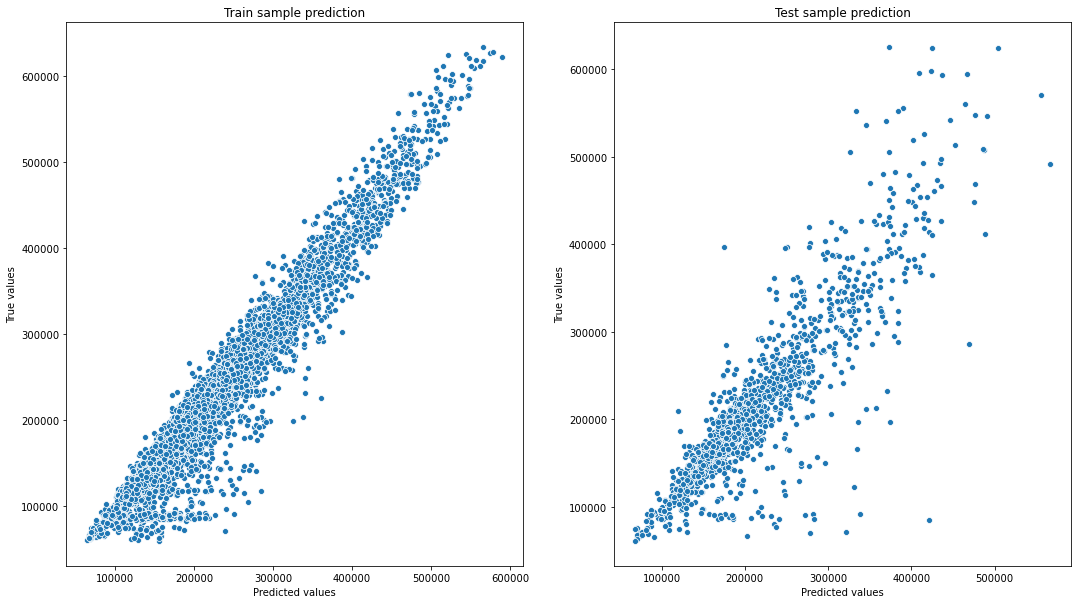

In [66]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

**Кросс-валидация**

In [67]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.74210585, 0.75181106, 0.7499325 ])

In [68]:
cv_score.mean()

0.7479498042625238

**Важность признаков**

In [69]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
2,Square,0.240321
15,DistrictPrice,0.152883
1,Rooms,0.124093
3,LifeSquare,0.092340
9,Social_2,0.053217
8,Social_1,0.044894
4,KitchenSquare,0.041673
17,Social,0.038569
6,HouseYear,0.034025
5,HouseFloor,0.027156


### 8. Прогнозирование на тестовом датасете  <a class='anchor' id='prediction'>

1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Не потерять и не перемешать индексы от примеров при построении прогнозов
3. Прогнозы должны быть для все примеров из тестового датасета (для всех строк)

In [70]:
test_df.shape

(5000, 18)

In [71]:
test_df

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Shops_1,DistrictYear,DistrictDensity,DistrictPrice,Floor_cat,Social
0,44,1.0,36.847630,19.094182,5.0,9.0,1970.0,0.036122,24,4378,0,1036.0,1,1977.0,46.971646,4431.704675,1,-1.654285
1,62,1.0,42.568133,42.493907,10.0,17.0,2017.0,0.072158,2,629,1,2300.0,0,1977.0,56.667328,2859.977368,1,-1.462656
2,27,2.0,59.463678,38.570943,9.0,19.0,1977.0,0.211401,9,1892,0,900.0,1,1977.0,55.064041,2654.571480,3,-1.659865
3,23,3.0,49.646030,33.893825,6.0,2.0,1965.0,0.014073,2,475,0,0.0,0,1977.0,54.345128,2093.831883,0,-1.662911
4,74,1.0,53.837056,42.069644,1.0,17.0,1977.0,0.309479,35,7715,4,990.0,6,1977.0,56.148572,3483.810063,2,-0.847631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,29,2.0,43.177521,30.339945,5.0,6.0,1962.0,0.069660,31,6119,4,1783.4,2,1966.0,42.460503,4190.624398,1,-0.850724
4996,38,3.0,94.521465,93.698122,10.0,27.0,2018.0,0.060753,15,2787,2,520.0,7,2011.0,65.410829,5033.548791,3,-1.257825
4997,101,1.0,33.656723,19.003259,5.0,5.0,1966.0,0.038693,28,6533,1,1015.0,5,1967.0,46.416381,3970.074724,0,-1.450241
4998,10,1.0,38.635155,20.976257,9.0,14.0,1970.0,0.089040,33,7976,5,900.0,11,1973.0,49.844005,4368.622761,2,-0.647366


In [72]:
submit = pd.read_csv(SAMPLE_DATASET_PATH)
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [73]:
predictions = rf_model.predict(test_df)
predictions

array([154743.65862831, 124011.57392321, 140555.03832373, ...,
       148593.55520105, 183912.23802055, 294715.47596434])

In [74]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,154743.658628
1,5925,124011.573923
2,960,140555.038324
3,3848,117772.840791
4,746,186703.339603


In [75]:
submit.to_csv(RESULT, index=False)